# Problem statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

In [ ]:
#Mounting the Google drive for importing the Data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Extracting the zip file
!unzip "/content/gdrive/MyDrive/Colab/Convolutional-Neural-Networks/Melanoma_Detection_Assignment/CNN_assignment.zip" > /dev/null

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
#Checking the count of images in Train and Test
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f"Number of Images in Train : {image_count_train}")
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f"Number of Images in Test : {image_count_test}")

Number of Images in Train : 2239
Number of Images in Test : 118


### Load using keras.preprocessing

Loading the images into the Dataset using keras.preprocessing

### Creating the dataset

In [ ]:
#Definng the parameters for loading the Dataset
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
#Creating the Train Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,  # Seed for shuffling
    validation_split=0.2,  # Set the portion of data to use for validation
    subset="training"  # Specify "training" to create a training dataset
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
#Creating the Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,  # Same seed for consistency
    validation_split=0.2,  # Same validation split as in training
    subset="validation"  # Specify "validation" for validation dataset
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(f"The classes for the data are :{class_names}")

The classes for the data are :['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

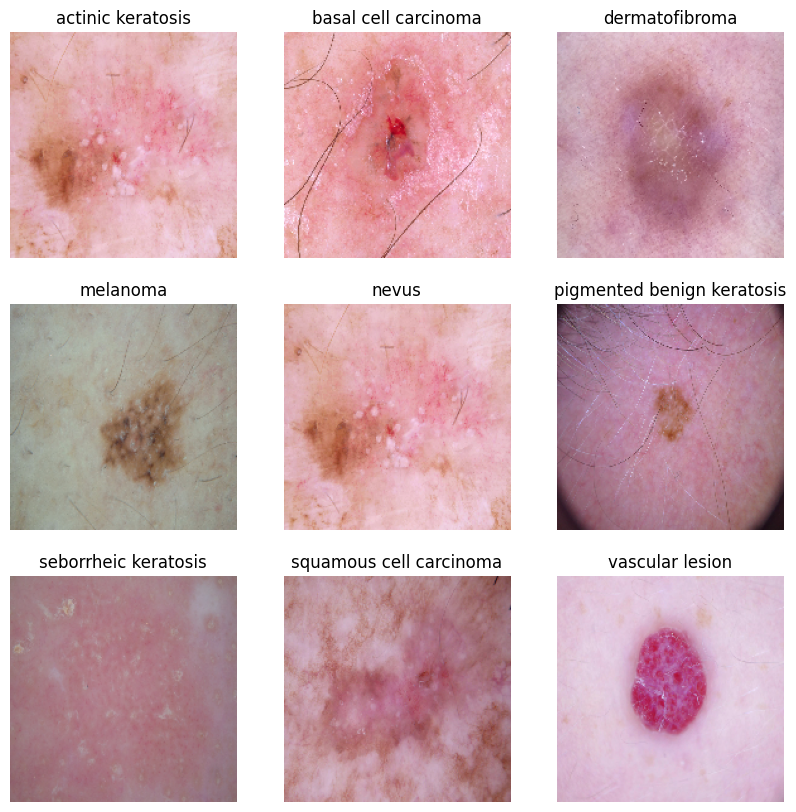

In [ ]:
#Visualizing the image from each class.
#Dictionary to store the path of image as per the class
files_path_dict = {}

for cls in class_names:
    files_path_dict[cls] = list(map(lambda x:str(data_dir_train)+'/'+ cls +'/'+x, os.listdir(str(data_dir_train)+'/'+ cls)))

#Visualize image
plt.figure(figsize=(10,10))
index = 0
for cls in class_names:
    path_list = files_path_dict[cls][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(tf.keras.preprocessing.image.load_img(path_list[0],target_size=(180,180)))
    plt.title(cls)
    plt.axis("off")


In [ ]:
#Checking the distribution of images in all the classes
class_distribution = {}
for cls in class_names:
  count = len(files_path_dict[cls])
  class_distribution[cls] = count

class_dist_df = pd.Series(class_distribution)
class_dist_df

actinic keratosis             114
basal cell carcinoma          376
dermatofibroma                 95
melanoma                      438
nevus                         357
pigmented benign keratosis    462
seborrheic keratosis           77
squamous cell carcinoma       181
vascular lesion               139
dtype: int64

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Creating the CNN model
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(180,180,3))) #Normalize pixel values to [0, 1]

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer ; Flatten the feature maps
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

# Output layer with 9 classes and softmax activation
model.add(layers.Dense(len(class_names),activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
#Compile the Model
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

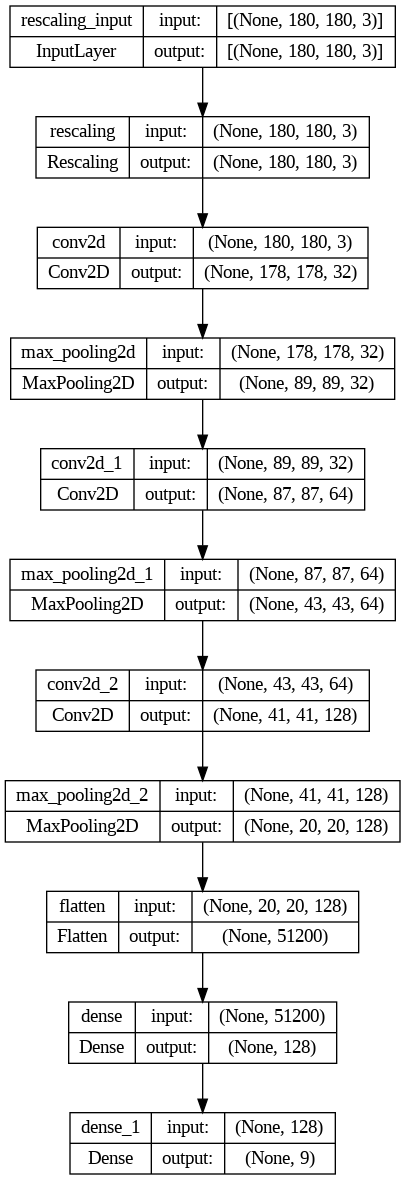

In [ ]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Train the model

In [ ]:
#Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 30s 92ms/step - loss: 2.1185 - accuracy: 0.1936 - val_loss: 2.0494 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 2s 36ms/step - loss: 1.8903 - accuracy: 0.3131 - val_loss: 1.7096 - val_accuracy: 0.3400
Epoch 3/20
56/56 [==============================] - 3s 48ms/step - loss: 1.5524 - accuracy: 0.4637 - val_loss: 1.4622 - val_accuracy: 0.4877
Epoch 4/20
56/56 [==============================] - 2s 35ms/step - loss: 1.4255 - accuracy: 0.5173 - val_loss: 1.4422 - val_accuracy: 0.5011
Epoch 5/20
56/56 [==============================] - 2s 35ms/step - loss: 1.3425 - accuracy: 0.5307 - val_loss: 1.4364 - val_accuracy: 0.5011
Epoch 6/20
56/56 [==============================] - 2s 38ms/step - loss: 1.2719 - accuracy: 0.5463 - val_loss: 1.4595 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 2s 43ms/step - loss: 1.2660 - accuracy: 0.5435 - val_loss: 1.3733 - val_accuracy: 0.5123
Epoch 8/20
5

### Visualizing training results

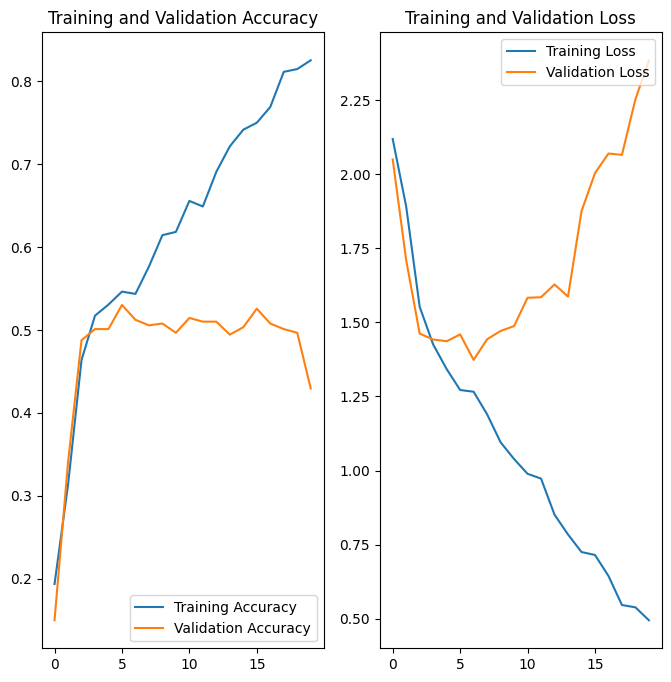

In [ ]:
#Visualizing the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation:
The training loss is 0.3024 and training accuracy is 0.8828 while the validation loss is 2.6583 and validation accuracy is 0.5526. This implies that the model is overfitting as there is substantial difference between the training and validation metrics.


In [ ]:
#Augmentation
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1)
  ]
)

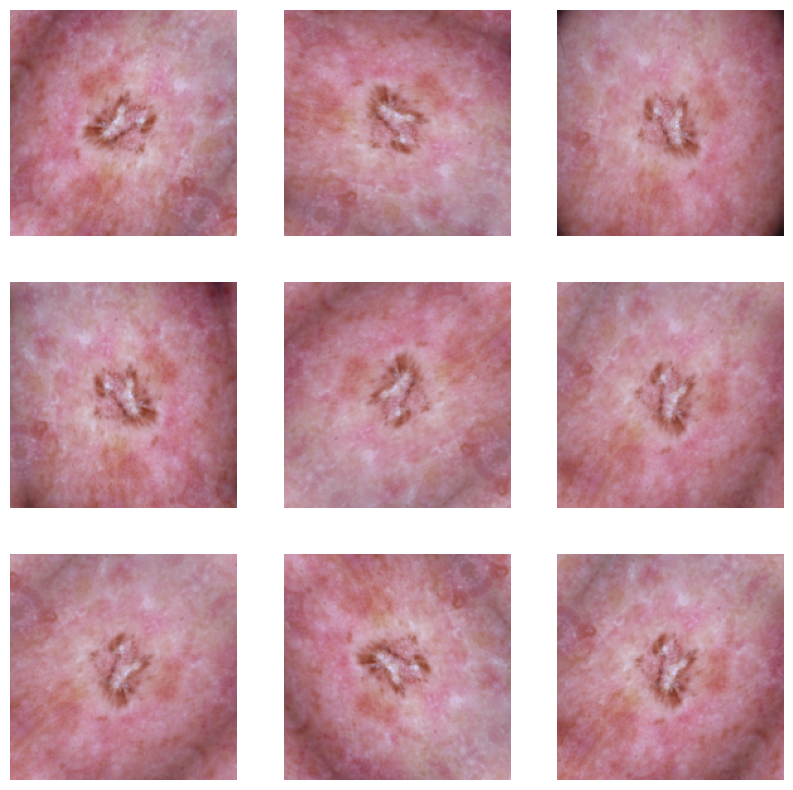

In [ ]:
#Visualizing one instance of trainging image
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
      augmented_images = data_augmentation(images)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_images[0].numpy().astype("uint8"))
      plt.axis("off")

### Create the model, compile and train the model


In [ ]:
### Creating the CNN model
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(180,180,3))) #Normalize pixel values to [0, 1]
model.add(data_augmentation)

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer ; Flatten the feature maps
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

# Output layer with 9 classes and softmax activation
model.add(layers.Dense(len(class_names),activation='softmax'))



### Compiling the model

In [ ]:
#Compile the Model
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [ ]:
##train the model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 40ms/step - loss: 2.0793 - accuracy: 0.2204 - val_loss: 1.8342 - val_accuracy: 0.3423
Epoch 2/20
56/56 [==============================] - 2s 36ms/step - loss: 1.6710 - accuracy: 0.3973 - val_loss: 1.4725 - val_accuracy: 0.4832
Epoch 3/20
56/56 [==============================] - 2s 36ms/step - loss: 1.4910 - accuracy: 0.4799 - val_loss: 1.4880 - val_accuracy: 0.4810
Epoch 4/20
56/56 [==============================] - 2s 36ms/step - loss: 1.4953 - accuracy: 0.4648 - val_loss: 1.3723 - val_accuracy: 0.5302
Epoch 5/20
56/56 [==============================] - 2s 37ms/step - loss: 1.4076 - accuracy: 0.5000 - val_loss: 1.3831 - val_accuracy: 0.5369
Epoch 6/20
56/56 [==============================] - 2s 39ms/step - loss: 1.3335 - accuracy: 0.5307 - val_loss: 1.3625 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.2969 - accuracy: 0.5329 - val_loss: 1.3446 - val_accuracy: 0.5168
Epoch 8/20
56

### Visualizing the results

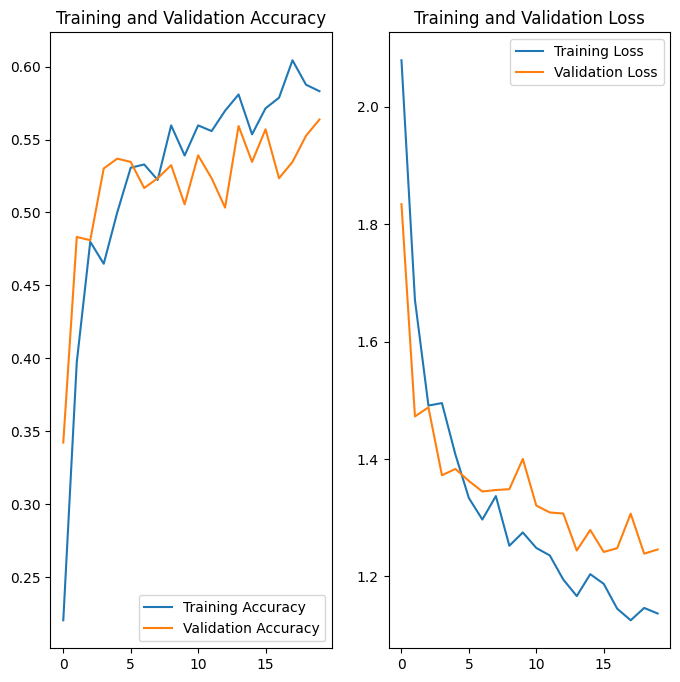

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation:
The overfitting has been handled as seen from above plot. The training accuracy and validation accuracy are similar around 55%.
The loss also seems to decreasing at a similar rate for training and validation data.

***Eventhough the overfitting has been handles, the accuracy is still on the lower end. ***

#### Distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
#checking the class distribution in the training dataset
class_distribution = {}
for cls in class_names:
  count = len(files_path_dict[cls])
  class_distribution[cls] = count

class_dist_df = pd.DataFrame(list(class_distribution.items()), columns=['Class', 'Count'])
class_dist_df

,Class,Count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


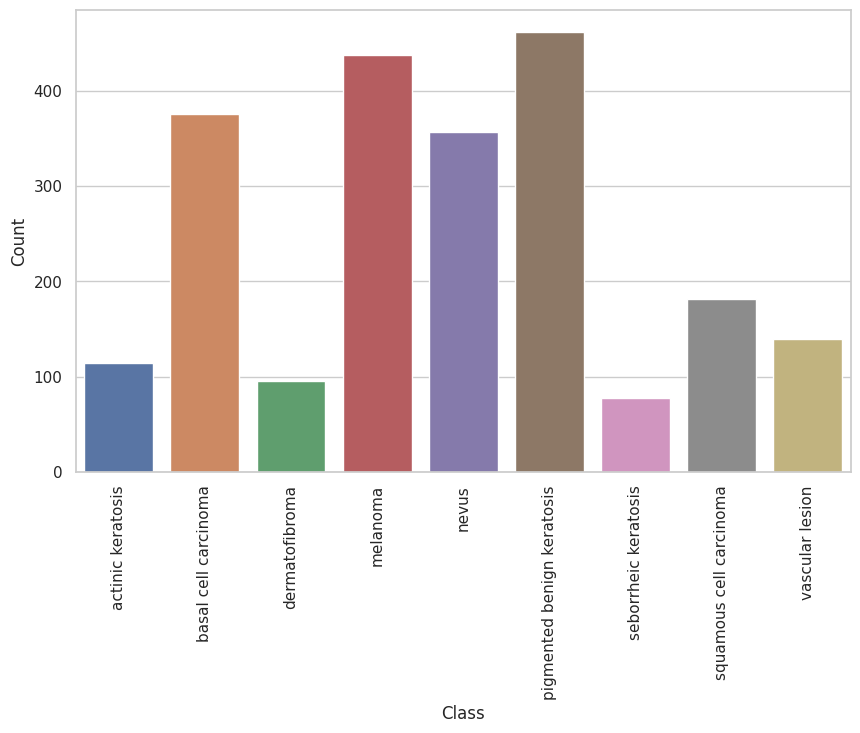

In [ ]:
# Using seaborn to check for class distribution
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(x= 'Class', y='Count', data=class_dist_df)
plt.xticks(rotation=90)
plt.show()

#### Findings:

#### -seborrheic keratosis has the least number of samples i.e. 77 Samples
#### - pigmented benign keratosis with 462 and melanoma with 438 dominate the entire dataset.


####Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x798D10185450>: 100%|██████████| 500/500 [00:19<00:00, 26.09 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x798CDB9F3D60>: 100%|██████████| 500/500 [00:18<00:00, 26.92 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x798D101ABA30>: 100%|██████████| 500/500 [00:20<00:00, 24.60 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x798D10142470>: 100%|██████████| 500/500 [01:12<00:00,  6.87 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x798D101AA7A0>: 100%|██████████| 500/500 [01:06<00:00,  7.47 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x798D10032B30>: 100%|██████████| 500/500 [00:16<00:00, 30.17 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x798D15F0CB80>: 100%|██████████| 500/500 [00:34<00:00, 14.69 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x798D241CAD40>: 100%|██████████| 500/500 [00:14<00:00, 34.19 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x798D278C0940>: 100%|██████████| 500/500 [00:14<00:00, 33.58 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028124.jpg_a2f84d6f-fa92-45cd-8ee8-6154accc451a.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026422.jpg_02a5bc20-e1f7-4e4b-a324-c5a768bdb586.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026606.jpg_5d14b0bf-dde5-4462-ad00-9ac6c3c74a04.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028201.jpg_61b94663-6b6d-4885-9043-697a407f7e6c.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024910.jpg_c0b42e84-3c25-43a5-9806-8e061945307a.jpg',


In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)
label_counts = df2['Label'].value_counts()
# Map the label counts to the 'Class' column in class_dist_df
class_dist_df['New_count'] = class_dist_df['Class'].map(label_counts)

In [ ]:
class_dist_df

,Class,Count,New_count
0,actinic keratosis,114,500
1,basal cell carcinoma,376,500
2,dermatofibroma,95,500
3,melanoma,438,500
4,nevus,357,500
5,pigmented benign keratosis,462,500
6,seborrheic keratosis,77,500
7,squamous cell carcinoma,181,500
8,vascular lesion,139,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [ ]:
#Definng the parameters for loading the Dataset
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [ ]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels="inferred",
  label_mode="categorical",
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels="inferred",
  label_mode="categorical",
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [ ]:
### Creating the CNN model
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(180,180,3))) #Normalize pixel values to [0, 1]

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# #Fourth Convulation Layer
model.add(layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Flatten Layer ; Flatten the feature maps
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))
model.add(Dropout(0.5))

# Output layer with 9 classes and softmax activation
model.add(layers.Dense(len(class_names),activation='softmax'))

#### Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
#Compile the Model
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
  model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 41, 41, 128)      

### Train your model

In [ ]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 35s 180ms/step - loss: 1.9295 - accuracy: 0.2661 - val_loss: 1.6986 - val_accuracy: 0.3601
Epoch 2/50
169/169 [==============================] - 30s 172ms/step - loss: 1.7029 - accuracy: 0.3479 - val_loss: 1.5077 - val_accuracy: 0.4083
Epoch 3/50
169/169 [==============================] - 32s 185ms/step - loss: 1.5706 - accuracy: 0.3984 - val_loss: 1.3747 - val_accuracy: 0.4707
Epoch 4/50
169/169 [==============================] - 30s 175ms/step - loss: 1.5200 - accuracy: 0.4139 - val_loss: 1.3856 - val_accuracy: 0.4477
Epoch 5/50
169/169 [==============================] - 30s 173ms/step - loss: 1.4727 - accuracy: 0.4267 - val_loss: 1.3611 - val_accuracy: 0.4246
Epoch 6/50
169/169 [==============================] - 36s 206ms/step - loss: 1.4159 - accuracy: 0.4453 - val_loss: 1.3333 - val_accuracy: 0.4647
Epoch 7/50
169/169 [==============================] - 30s 175ms/step - loss: 1.3760 - accuracy: 0.4707 - val_loss: 1.3558 - val_ac

#### **Todo:**  Visualize the model results

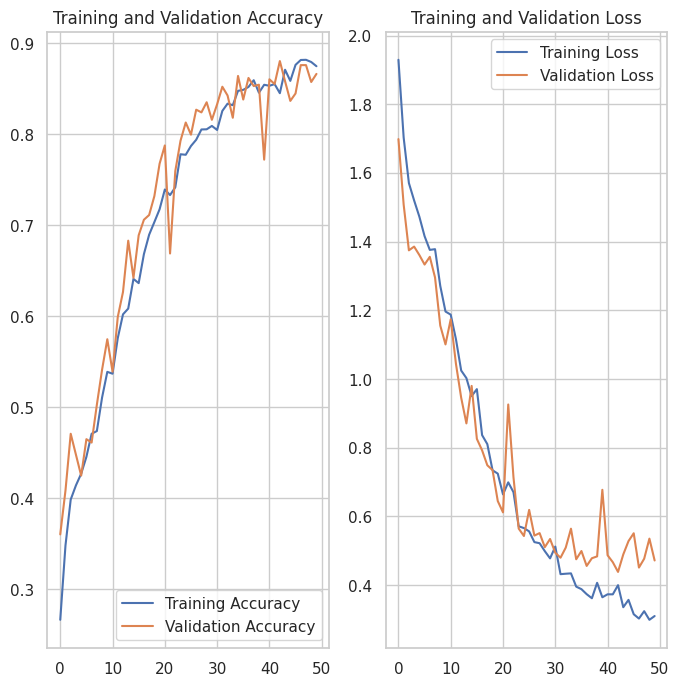

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation:
We have handles the overfitting by augmenting and adding images to each class to counter the class imbalanace.

We have the training accuracy as 0.8748 and validation accuracy as 0.8664.



In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test, image_size=(img_width, img_height), shuffle=False, batch_size=120)

# Create an empty list to store the true labels
true_labels = []

# Iterate through the test dataset to extract true labels
for images, labels in test_ds:
    true_labels.extend(labels.numpy())

# Convert true_labels to a numpy array
true_labels = np.array(true_labels)

# Make predictions
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=-1)

from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print('Test Accuracy:', accuracy)


Found 118 files belonging to 9 classes.
1/1 [==============================] - 6s 6s/step
Test Accuracy: 0.4067796610169492


1/1 [==============================] - 0s 60ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


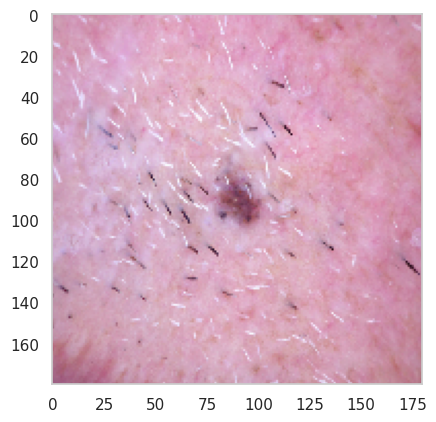

In [ ]:

from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[2],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )